**Notebook Contents**
- [Imports](#Imports)
- [Data import](#Read-in-data)
- [Data Cleaning](#Clean-Data)
- [Categorical Encoding](#Convert-ordinal-and-categorical-data-to-numeric)
- [Feature Selection](#Feature-Selection)
- [Model pre-processing](#Model-Pre-Processing)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Make Predicitons](#Make-Predicitons)

###can add images and link them

### Imports

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score


plt.style.use('dark_background')

In [192]:
train = pd.read_csv("./datasets/train.csv")
kaggle = pd.read_csv("./datasets/test.csv")

In [193]:
print(f'The training data has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'The Kaggle data has {kaggle.shape[0]} rows and {kaggle.shape[1]} columns.')

The training data has 2051 rows and 81 columns.
The Kaggle data has 878 rows and 80 columns.


In [194]:
train.columns = train.columns.str.replace(" ", "_").str.lower()
kaggle.columns = kaggle.columns.str.replace(" ", "_").str.lower()

In [307]:
train.rename(columns={"id": "Id"}, inplace=True)
kaggle.rename(columns={"id": "Id"}, inplace=True)

#### Check nulls

In [196]:
train.isnull().sum()[train.isnull().mean() > 0.2].sort_values(ascending=False)

pool_qc         2042
misc_feature    1986
alley           1911
fence           1651
fireplace_qu    1000
dtype: int64

I am checking all the columns that are missing more thna 20 % and replacing them

In [197]:
very_miss_vow = train.isnull().sum()[train.isnull().mean() > 0.2].sort_values(ascending=False).index

In [198]:
train.loc[:, very_miss_vow] = train.loc[:, very_miss_vow].replace(np.nan, "NA")
kaggle.loc[:, very_miss_vow] = kaggle.loc[:, very_miss_vow].replace(np.nan, "NA")

# Clean-Data

Check that this method worked

In [199]:
train.loc[:, very_miss_vow].isnull().sum()

pool_qc         0
misc_feature    0
alley           0
fence           0
fireplace_qu    0
dtype: int64

### Convert ordinal and categorical data to numeric

In [200]:
cat_replace_dict = {'Ex':5,
                    'Gd':4,
                    'TA':3,
                    'Fa':2,
                    'Po':1,
                    'NA':0}

In [201]:
cat_cols = list(train.columns[train.columns.str.contains('cond')]) + list (train.columns[train.columns.str.contains('qual')])

In [202]:
cat_cols

['condition_1',
 'condition_2',
 'overall_cond',
 'exter_cond',
 'bsmt_cond',
 'garage_cond',
 'overall_qual',
 'exter_qual',
 'bsmt_qual',
 'low_qual_fin_sf',
 'kitchen_qual',
 'garage_qual']

In [203]:
# train.filter(regex="cond")

In [204]:
train.loc[:, cat_cols] = train.loc[:, cat_cols].replace(cat_replace_dict)
kaggle.loc[:, cat_cols] = kaggle.loc[:, cat_cols].replace(cat_replace_dict)

In [205]:
train.loc[:, cat_cols].isnull().sum()

condition_1          0
condition_2          0
overall_cond         0
exter_cond           0
bsmt_cond           55
garage_cond        114
overall_qual         0
exter_qual           0
bsmt_qual           55
low_qual_fin_sf      0
kitchen_qual         0
garage_qual        114
dtype: int64

In [206]:
train.loc[:, cat_cols].replace(np.nan, 0).isnull().sum()

condition_1        0
condition_2        0
overall_cond       0
exter_cond         0
bsmt_cond          0
garage_cond        0
overall_qual       0
exter_qual         0
bsmt_qual          0
low_qual_fin_sf    0
kitchen_qual       0
garage_qual        0
dtype: int64

In [207]:
train.loc[:, cat_cols] = train.loc[:, cat_cols].replace(np.nan, 0)

In [208]:
###checking if the values changed correctly without changing the dtypes

In [209]:
train.loc[:, cat_cols].dtypes

condition_1        object
condition_2        object
overall_cond        int64
exter_cond          int64
bsmt_cond           int64
garage_cond         int64
overall_qual        int64
exter_qual          int64
bsmt_qual           int64
low_qual_fin_sf     int64
kitchen_qual        int64
garage_qual         int64
dtype: object

### Feature selection

In [210]:
train.corr()["saleprice"].abs().sort_values(ascending=False) 

saleprice          1.000000
overall_qual       0.800207
exter_qual         0.712146
gr_liv_area        0.697038
kitchen_qual       0.692336
garage_area        0.650270
garage_cars        0.648220
total_bsmt_sf      0.628925
1st_flr_sf         0.618486
bsmt_qual          0.612188
year_built         0.571849
year_remod/add     0.550370
full_bath          0.537969
garage_yr_blt      0.533922
mas_vnr_area       0.512230
totrms_abvgrd      0.504014
fireplaces         0.471093
bsmtfin_sf_1       0.423519
lot_frontage       0.341842
open_porch_sf      0.333476
wood_deck_sf       0.326490
lot_area           0.296566
garage_qual        0.285281
bsmt_full_bath     0.283662
half_bath          0.283001
garage_cond        0.265021
pid                0.255052
2nd_flr_sf         0.248452
bsmt_cond          0.225075
bsmt_unf_sf        0.190210
bedroom_abvgr      0.137067
enclosed_porch     0.135656
screen_porch       0.134581
kitchen_abvgr      0.125444
overall_cond       0.097019
ms_subclass        0

In [211]:
train.corr()['saleprice'][train.corr()['saleprice'].abs() > 0.5 ].sort_values(ascending=False)

saleprice         1.000000
overall_qual      0.800207
exter_qual        0.712146
gr_liv_area       0.697038
kitchen_qual      0.692336
garage_area       0.650270
garage_cars       0.648220
total_bsmt_sf     0.628925
1st_flr_sf        0.618486
bsmt_qual         0.612188
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
garage_yr_blt     0.533922
mas_vnr_area      0.512230
totrms_abvgrd     0.504014
Name: saleprice, dtype: float64

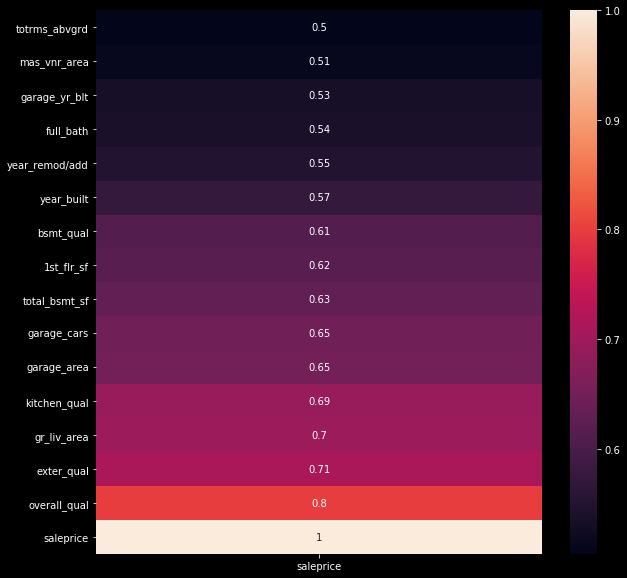

In [212]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr()[['saleprice']][train.corr()['saleprice'].abs() > 0.5].sort_values(by='saleprice', ascending=False), annot=True, )
plt.ylim(0, 16);

### Model Pre-Processing

In [312]:
features = list(train.corr()[['saleprice']][train.corr()['saleprice'].abs() >= 0.5].sort_values(by='saleprice', ascending=False).index)
# festures = list(train.corr()[['saleprice']].sort_values(by='saleprice', ascending=False).index)
features

['saleprice',
 'overall_qual',
 'exter_qual',
 'gr_liv_area',
 'kitchen_qual',
 'garage_area',
 'garage_cars',
 'total_bsmt_sf',
 '1st_flr_sf',
 'bsmt_qual',
 'year_built',
 'year_remod/add',
 'full_bath',
 'garage_yr_blt',
 'totrms_abvgrd',
 'mas_vnr_area']

#### Remove our target variable from the list

In [313]:
features.remove("saleprice")
# train.at[train["garage_yr_blt"].isnull(),"garage_yr_blt"] = train[-train["garage_yr_blt"].isnull()]["garage_yr_blt"].mode()[0]
train.loc[train["mas_vnr_type"].isnull(), ["mas_vnr_type", "mas_vnr_area"]] = ["None", 0]

In [314]:
train[features].isnull().sum().sort_values(ascending=False)
train.loc[train['garage_area'].isnull() | train['total_bsmt_sf'].isnull(), ['garage_area', 'garage_cars', 'total_bsmt_sf']]
train.loc[1327, 'total_bsmt_sf'] = 0
train.loc[1712, 'garage_area'] = 0
train.loc[1712, 'garage_cars'] = 0

In [315]:
def normalize(x):
    return x ** 1/15

def get_exp(x):
    return x ** 15

In [316]:
X = train[features]
y = train["saleprice"].map(normalize)

Train-test split

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Modelling

In [294]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [295]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [296]:
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print('Train MSE: {}'.format(train_mse))
print('Test MSE: {}'.format(test_mse))

if train_mse > test_mse:
    print("Model is overfit !!")

Train MSE: 9359916.930241102
Test MSE: 8532505.19279583
Model is overfit !!


In [297]:
train_rmse = mean_squared_error(y_train, train_preds) ** (1/2)
test_rmse = mean_squared_error(y_test, test_preds) ** (1/2)

print("Train RMSE : {}".format(train_rmse))
print("Test RMSE : {}".format(test_rmse))

Train RMSE : 3059.3981320254975
Test RMSE : 2921.0452226550397


In [298]:
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train R-squared: {}".format(train_r2))
print("Test R-squared: {}".format(test_r2))

Train R-squared: 0.6670132699711582
Test R-squared: 0.6873280234684256


### Cross validation

In [299]:
cross_val_score(lr, X_train, y_train, cv=5)

array([0.67328048, 0.67709769, 0.67609266, 0.68536557, 0.58889183])

### Make predictions

In [225]:
kaggle[features].isnull().sum()

overall_qual       0
exter_qual         0
gr_liv_area        0
kitchen_qual       0
garage_area        0
garage_cars        0
total_bsmt_sf      0
1st_flr_sf         0
bsmt_qual         25
year_built         0
year_remod/add     0
full_bath          0
mas_vnr_area       1
totrms_abvgrd      0
dtype: int64

In [226]:
kaggle.loc[: , features] = kaggle.loc[: , features].replace(np.nan, 0)

In [228]:
prediction_data = kaggle[features]

In [241]:
kaggle_preds = lr.predict(prediction_data)
len(kaggle_preds)

878

In [244]:
pd.DataFrame(kaggle["Id"]).shape

(878, 1)

In [248]:
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [255]:
kaggle_predictions.to_csv("./submissions/1-features-predictions.csv", index=False)

In [317]:
kaggle_predictions["SalePrice"].mean()

179095.90917031016

In [256]:
features

['overall_qual',
 'exter_qual',
 'gr_liv_area',
 'kitchen_qual',
 'garage_area',
 'garage_cars',
 'total_bsmt_sf',
 '1st_flr_sf',
 'bsmt_qual',
 'year_built',
 'year_remod/add',
 'full_bath',
 'mas_vnr_area',
 'totrms_abvgrd']